In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as functionnal
from torchvision import transforms
import torch.nn.intrinsic as intr
import torchvision
import matplotlib.pyplot as plt
import os
import requests
from io import BytesIO
import PIL.Image
import tqdm
import numpy as np

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = 'cpu'


In [ ]:
#GetData
import zipfile
from google.colab import drive
drive.mount('/content/drive')
if not os.path.isdir('targetdir/'):
  with zipfile.ZipFile("drive/MyDrive/DataIA/FFHQSynthPhotos.zip","r") as zip_ref:
      zip_ref.extractall("targetdir")

  with zipfile.ZipFile("drive/MyDrive/DataIA/archive.zip","r") as zip_ref:
      zip_ref.extractall("targetdir")

Mounted at /content/drive


In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

real_path = "/content/targetdir/archive"
x_path = "/content/targetdir/FFHQSynthPhotos"

batch_size = 16

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
class Clamp(object):
    def __init__(self, min, max):
        self.min = float(min)
        self.max = float(max)

    def __call__(self, x):
        new_x = torch.clamp(x, self.min, self.max)
        
        return new_x

class Permute(object):
    def __init__(self, dims):
        self.dims = dims

    def __call__(self, x):
        new_x = x.permute(*self.dims)
        
        return new_x

preprocessing = transforms.Compose([transforms.Resize((256, 256)),
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=IMAGENET_MEAN,
                                                         std=IMAGENET_STD),
                                   ])

mean = torch.tensor(IMAGENET_MEAN, dtype=torch.float32)
std = torch.tensor(IMAGENET_STD, dtype=torch.float32)

postprocessing = transforms.Compose([
                                     transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist()),
                                     #Permute((1, 2, 0)),
                                     Clamp(0, 1),
                                    ])

class CreateDataSet(Dataset):
    def __init__(self, path_r,path_x):
        self.files_r = [os.path.join(path_r, f) for f in os.listdir(path_r)]
        self.files_x = [os.path.join(path_x, f) for f in os.listdir(path_x)]

    def __getitem__(self, index):
        img_r=self.Read_image(self.files_r[index]);
        img_x=self.Read_image(self.files_x[index]);
        return img_r,img_x

    def Read_image(self,name):
        img = PIL.Image.open(name).convert('RGB')

        return preprocessing(img)

    def __len__(self):
      return min([len(self.files_r),len(self.files_x)])   # Need a better way, might not use some part of the data


data_set = CreateDataSet(real_path,x_path)
train_len = int(len(data_set)*0.9)
train_set, test_set = random_split(data_set, [train_len, len(data_set) - train_len])

data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=False,num_workers=5)
#test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,num_workers=5)

In [ ]:
#VGG


#Code provenant de https://gist.github.com/alper111/8233cdb0414b4cb5853f2f730ab95a49

import torchvision.models as models

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
 #       input = (input-self.mean) / self.std
  #      target = (target-self.mean) / self.std
   #     if self.resize:
    #        input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
     #       target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)
        return loss


In [ ]:
class CondInstNorm(nn.Module):
    def __init__(self,N_in_latent,N_in_degraded_face):
        super().__init__()
        self.norm_layer = nn.InstanceNorm2d(N_in_latent, affine=False)
        nhidden = 128
        kw=3;
        self.mlp = nn.Sequential(nn.Conv2d(N_in_degraded_face, nhidden, kernel_size=kw, padding=kw//2), nn.ReLU())
        self.gamma = nn.Conv2d(nhidden, N_in_latent, kernel_size=kw, padding=kw//2)
        self.beta = nn.Conv2d(nhidden, N_in_latent, kernel_size=kw, padding=kw//2)

    def forward(self, x, featmap_degraded): # is conv ouptut from z and featmap_degraded is computed from the degraded face out. 
        inst_normalized = self.norm_layer(x)
        featmap_degraded = functionnal.interpolate(featmap_degraded, size=x.size()[2:], mode="nearest")
        ml_out = self.mlp(featmap_degraded)
        gamma = self.gamma(ml_out)
        beta = self.beta(ml_out)
        out = inst_normalized * (1 + gamma) + beta
        return out


In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, activation=nn.ReLU(False), kernel_size=3):
        super().__init__()

        pw = (kernel_size - 1) // 2
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(pw),
            nn.Conv2d(dim, dim, kernel_size=kernel_size),
            nn.BatchNorm2d(dim),
            activation,
            nn.ReflectionPad2d(pw),
            nn.Conv2d(dim, dim, kernel_size=kernel_size),
            nn.BatchNorm2d(dim),

        )

    def forward(self, x):
        y = self.conv_block(x)
        out = x + y
        return out



class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    input_nc = 3
    ngf = 64
    resnet_initial_kernel_size = 7
    resnet_n_downsample = 4
    resnet_n_blocks = 3
    resnet_kernel_size  = 3
    output_nc = 3
    
    self.init = nn.Sequential(
                  nn.ReflectionPad2d(resnet_initial_kernel_size // 2),
                  nn.Conv2d(input_nc, ngf, kernel_size=resnet_initial_kernel_size, padding=0),
                  nn.BatchNorm2d(ngf),
                  nn.ReLU(False)
                )


    self.down1 =  nn.Sequential(
                    nn.Conv2d(ngf , ngf * 2, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(ngf * 2),
                    nn.ReLU(False)
                  )
    
    self.down2 =  nn.Sequential(
                    nn.Conv2d(ngf *2, ngf * 4, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(ngf * 4),
                    nn.ReLU(False)
                   )
    
    self.down3 =  nn.Sequential(
                    nn.Conv2d(ngf * 4, ngf * 8, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(ngf * 8),
                    nn.ReLU(False)
                  )
    
    self.down4 =  nn.Sequential(
                    nn.Conv2d(ngf * 8, ngf * 16, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(ngf * 16),
                    nn.ReLU(False)
                  )
    

    self.resnet = nn.Sequential(
        ResnetBlock(ngf * 16, activation=nn.ReLU(False), kernel_size=resnet_kernel_size,),
        ResnetBlock(ngf * 16, activation=nn.ReLU(False), kernel_size=resnet_kernel_size,),
        ResnetBlock(ngf * 16, activation=nn.ReLU(False), kernel_size=resnet_kernel_size,),
    )

    self.up1= nn.Sequential(
        nn.ConvTranspose2d(ngf * 16, ngf * 8, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(False),
    )

    self.up2= nn.Sequential(
        nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(False),
    )

    self.up3= nn.Sequential(

        nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(False),
    )

    self.up4= nn.Sequential(
        nn.ConvTranspose2d(ngf*2, ngf, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(ngf),
        nn.ReLU(False),
    )

    self.fin= nn.Sequential(
        nn.ReflectionPad2d(3),
        nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
        nn.Tanh(),
    )

    self.model = nn.Sequential(
        nn.ReflectionPad2d(resnet_initial_kernel_size // 2),
        nn.Conv2d(input_nc, ngf, kernel_size=resnet_initial_kernel_size, padding=0),
        nn.BatchNorm2d(ngf),
        nn.ReLU(False),

        nn.Conv2d(ngf , ngf * 2, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(False),

        nn.Conv2d(ngf *2, ngf * 4, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(False),

        nn.Conv2d(ngf * 4, ngf * 8, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(False),

        nn.Conv2d(ngf * 8, ngf * 16, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(ngf * 16),
        nn.ReLU(False),

        ResnetBlock(ngf * 16, activation=nn.ReLU(False), kernel_size=resnet_kernel_size,),
        ResnetBlock(ngf * 16, activation=nn.ReLU(False), kernel_size=resnet_kernel_size,),
        ResnetBlock(ngf * 16, activation=nn.ReLU(False), kernel_size=resnet_kernel_size,),

        nn.ConvTranspose2d(ngf * 16, ngf * 8, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(False),

        nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(False),

        nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(False),

        nn.ConvTranspose2d(ngf*2, ngf, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(ngf),
        nn.ReLU(False),

        nn.ReflectionPad2d(3),
        nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
        nn.Tanh(),
    )

    self.cbn1 = CondInstNorm(128,3)
       
    self.cbn2 = CondInstNorm(256,3)
    self.cbn3 = CondInstNorm(512,3)
    self.cbn4 = CondInstNorm(1024,3)


  def forward(self, x):

    init = self.init(x)
    down1 = self.down1(init)
    test1 = self.cbn1(down1,x)

    down2 = self.down2(down1)

    test2 = self.cbn2(down2,x)
  

    down3 = self.down3(down2)
    test3 = self.cbn3(down3,x)

    down4 = self.down4(down3)
    test4 = self.cbn4(down4,x)

    resnet = self.resnet(down4)

    up1 = self.up1(resnet+test4)

    up2 = self.up2(up1+test3)
    up3 = self.up3(up2+test2)
    up4 = self.up4(up3+test1)
    output = self.fin(up4)



    return output


class Discriminator(nn.Module):
  def __init__(self,nChannels=3, ndf=64):
    super().__init__()
    kw = 3
    pw = int(np.ceil((kw - 1.0) / 2))

    self.conv = nn.Sequential(
        nn.Conv2d(3, ndf, kw, stride=2, padding=pw),
        nn.BatchNorm2d(ndf),

        nn.Conv2d(ndf * 1, ndf * 2, kw, stride=2, padding=pw),
        nn.BatchNorm2d(ndf*2),

        nn.Conv2d(ndf * 2, ndf * 4, kw, stride=2, padding=pw),
        nn.BatchNorm2d(ndf*4),

        nn.Conv2d(ndf * 4, ndf * 8, kw, stride=2, padding=pw),
        nn.BatchNorm2d(ndf*8),

        nn.Conv2d(ndf * 8, ndf * 8, kw, stride=2, padding=pw),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2, False)
    )

    

  def forward(self, x):
      if x.size(2) != 256 or x.size(3) != 256:
        x = F.interpolate(x, size=(256, 256), mode="bilinear")

      x = self.conv(x)
      x = x.view(x.size(0), -1)

      return x

 65%|██████▍   | 471/730 [06:22<03:29,  1.24it/s]

KeyboardInterrupt: ignored

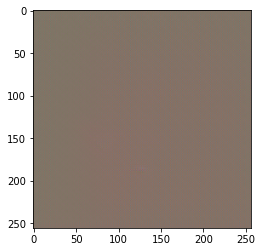

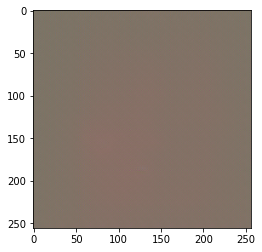

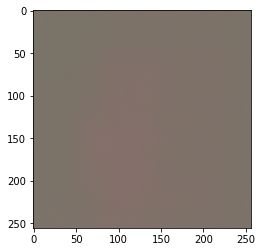

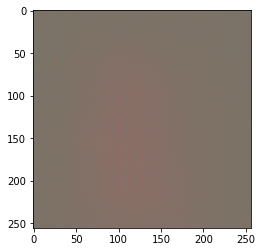

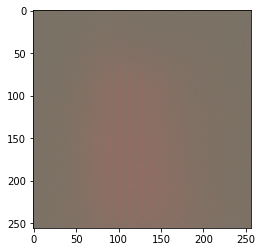

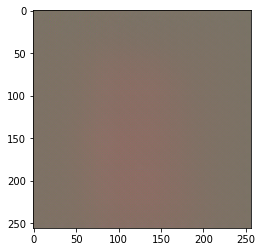

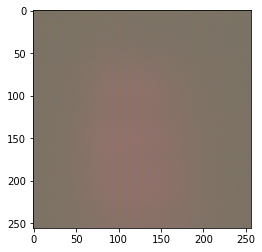

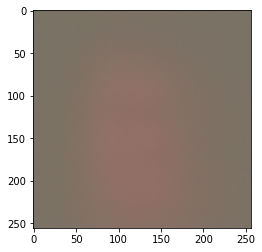

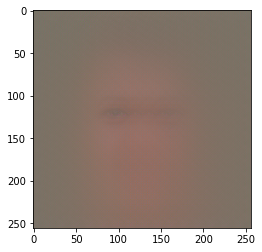

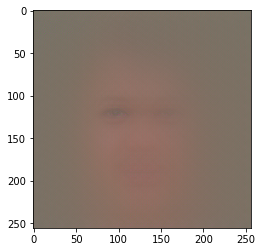

In [ ]:

epochs = 100
netG = Generator().to(device)
vgg = VGGPerceptualLoss().to(device)

netD = Discriminator().to(device)

optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        netG.train()
        netD.train();
        train_lossG = 0.;
        train_lossD = 0.;


        

        for samp_real,samp_x in tqdm.tqdm(data_loader, total=int(len(data_loader)),position=0, leave=True):
            samp_real = samp_real.to(device)
            samp_x = samp_x.to(device)

            ##Generator Loss
            optimizerG.zero_grad()

#            label_real = torch.full((len(samp_real),), 1,dtype=samp_real.dtype, device=device)
#            label_fake = torch.full((len(samp_x),), 0,dtype=samp_real.dtype, device=device)
            if(samp_x.size()[0] == 16):
              fake_image = netG(samp_x)


              discriminator_out_fakeG = netD(fake_image)

              GLoss = vgg(samp_real,fake_image) +torch.mean((1-discriminator_out_fakeG)**2)
              GLoss.backward()
              optimizerG.step()

              optimizerD.zero_grad()

              with torch.no_grad():
                fake_image = netG(samp_x)
                fake_image = fake_image.detach()


              discriminator_out_fake = netD(fake_image)
              discriminator_out_real = netD(samp_real)

              DLoss = vgg(fake_image, samp_real) +torch.mean((1-discriminator_out_real)**2) + torch.mean((discriminator_out_fake)**2)
              DLoss.backward()
              optimizerD.step()



          #  print('Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
           
           #         % (DLoss.item(), GLoss.item(), discriminator_out_real.mean().item(), discriminator_out_fake.mean().item(), discriminator_out_fakeG.mean().item() ))
            
        with torch.no_grad():
          netG.eval()

          for samp_real,samp_x in data_loader:
              samp_x = samp_x.to(device)
              sample_fake = netG(samp_x)
              fig=plt.figure()
              plt.imshow(np.transpose(postprocessing(sample_fake[0]).detach().cpu().numpy(),(1,2,0)))
              break;
           

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


#%%capture
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

AttributeError: ignored

In [ ]:
iter_data = iter(data_loader)

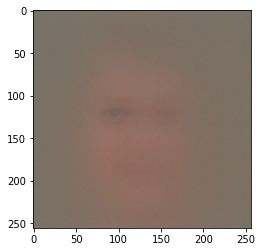

In [ ]:
img1,img2=next(iter_data)
fake = netG(img2.to(device))

plt.imshow(np.transpose(postprocessing(fake[0].detach().cpu()),(1,2,0)))
#plt.imshow(np.transpose(postprocessing(img2[0].detach().cpu()),(1,2,0)))

#for samp_real,samp_x in data_loader:
 #   samp_real = samp_real.to(device)
  #  fake = netG(samp_real)
   # print(netD(samp_real).mean().item())
    #plt.imshow(np.transpose(postprocessing(fake[0].detach().cpu()),(1,2,0)))

